# Xử lý dữ liệu và tạo file_dataset

In [ ]:
import os
import json
import music21 as m21
import numpy as np
import tensorflow.keras as keras
from tqdm import tqdm
import glob
from keras.layers import Layer
import keras.backend as K

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/model LSTM /

/content/drive/.shortcut-targets-by-id/1N-fES5cxjE4SDbEpWUZ5lpoNeLzsphR6/model LSTM 


## preprocess

các biến và path có thể dùng lại


In [ ]:
DATASET_PATH = "./data/*/*/*.*"
SAVE_DIR = "./dataset/"
SINGLE_FILE_DATASET = "./file_dataset (1)"
MAPPING_PATH = "./mapping.json"
SEQUENCE_LENGTH = 64

# nếu nốt tròn = 4 đơn vị đo độ dài (đv/nhịp) thì các nốt còn lại sẽ có giá trị như sau:
ACCEPTABLE_DURATIONS = [
    0.25, # note moc doi 1/16
    # 0.375, # .
    0.5, # note moc don 1/8
    0.75, # .
    # 0.875, # ..
    1.0, # note den 1/4
    1.5, # .
    1.75, # ..
    2, # note trắng 1/2
    3, # .
    3.5, # ..
    4, # note tron 1
    6, # .
    7 # ..
]

In [ ]:




def load_songs_in_kern_midi(dataset_path):
    """sử dụng music21 để load tất cả các bài hát dạng midi hay krn.

    :param dataset_path (str): đường dẫn tới dataset
    :return songs (danh sách m21 streams): Danh sách chứa tất cả các streams bài hát
    """
    songs = []

    # tìm và load các các file krn và midi => list songs
    for file in tqdm(glob.glob(dataset_path), desc="load được..."):
        try:
          # chỉ chọn file đuôi .krn hoặc .mid
          if file[-3:] == "krn" or file[-3:] == "mid":
              song = m21.converter.parse(file)
              songs.append(song)
        except:
          print(f"Lỗi tại {file}")
    return songs

def has_acceptable_durations(song):
    """trả về True nếu nốt đó có thời lượng chấp nhận được (là bội của nốt nhỏ nhất là nốt móc đôi = 0.25).

    :param song (m21 stream): bài hát
    :return (bool):
    """
    # duyệt các note trong bài hát
    for note in song.flat.notesAndRests:
        # kiểm tra thời gian của nốt đó
        if note.duration.quarterLength%0.25!=0:
            return False
    return True


def transpose(song):
    """chuyển tông bài hát về C maj/A min

    :param song (m21 stream): bài hát cần chuyển về Đô trưởng/ La thứ
    :return transposed_song (m21 stream):
    """

    # lấy key từ khuôn nhạc 
    parts = song.getElementsByClass(m21.stream.Part)
    measures_part0 = parts[0].getElementsByClass(m21.stream.Measure)
    key = measures_part0[0][4]

    # ước lượng key từ các nốt nhạc trong bài hát
    if not isinstance(key, m21.key.Key):
        key = song.analyze("key")

    # tính khoảng cách từ key hiện tại tới key Cmaj/Amin. E.g., Bmaj -> Cmaj
    if key.mode == "major":
        interval = m21.interval.Interval(key.tonic, m21.pitch.Pitch("C"))
    elif key.mode == "minor":
        interval = m21.interval.Interval(key.tonic, m21.pitch.Pitch("A"))

    # chuyển bài hát sang key Cmaj/Amin 
    tranposed_song = song.transpose(interval)
    return tranposed_song


def encode_song(song, time_step=0.25):
    """chuyển bản nhạc thành chuỗi thời gian. mỗi 1 "ký hiệu" trong encoded là một nốt móc đôi . 
    ký hiệu sử dụng là số trên MIDI note number, 'r' là nốt lặng 'rest', 
    và '_' là  notes/rests that are được chuyển sang một bước thời gian mới. mẫu encoded như này:

        ["r", "_", "60", "_", "_", "_", "72" "_"]

    :param song (m21 stream): bài hát cần encode
    :param time_step (float): thời gian cho từng bước thời gian, ở đây là note móc đôi = 0.25
    :return:
    """
    encoded_song = []
    # duyệt các nốt hay nghỉ trong bài hát
    for event in song.flat.notesAndRests:

        # kiểm tra event là nốt hay nghỉ 
        # nếu là nốt nhạc thì chuyển thành số MIDI
        if isinstance(event, m21.note.Note):
            symbol = event.pitch.midi # 60
        # kiểm tra nếu là nốt lặng thì gán thành 'r'
        elif isinstance(event, m21.note.Rest):
            symbol = "r"
        # nếu là hợp âm thì lấy nốt có số Midi lớn nhất 
        elif isinstance(event, m21.chord.Chord):
            symbol = max(event.pitches).midi
        
        # chuyển nốt nhạc/ nốt lặng thành ký hiệu trên chuỗi thời gian
        # số ký hiệu bằng thời gian cả nốt / thời gian 1 bước
        steps = int(event.duration.quarterLength / time_step)
        for step in range(steps):

            # ở bước đầu tiên là ký hiệu của nốt nhạc/nốt lặng
            # các bước còn lại sẽ là "_" có nghĩa là cùng mang 1 nốt ở trên
            if step == 0:
                encoded_song.append(symbol)
            else:
                encoded_song.append("_")

    # chuyển thành chuỗi cách nhau 1 khoảng trắng
    encoded_song = " ".join(map(str, encoded_song))

    return encoded_song


def preprocess(dataset_path,save_dir):

    # 
    # filenames = glob.glob(dataset_path)
    songs = load_songs_in_kern_midi(dataset_path)
    # print(f"Loaded {len(songs)} songs.")
    i = 1
    for song in tqdm(songs, desc="Loading..."):
        
        if not has_acceptable_durations(song):
            continue
        # chuyển bài hát về key Cmaj/Amin
        song = transpose(song)
        # encode 
        encoded_song = encode_song(song)
        # lưu bài hát về text
        save_path = os.path.join(save_dir,str(i))
        with open(save_path, "w") as fp:
            fp.write(encoded_song)
        # print(f"bai so {i} trong {len(songs)} duoc xu ly")
        i+=1


def load(file_path):
    with open(file_path, "r") as fp:
        song = fp.read()
    return song


def create_single_file_dataset(dataset_path, file_dataset_path, sequence_length):
    """tổng hợp các bài hát phân cách bởi chuỗi ký hiệu '/'

    :param dataset_path (str): Path to folder containing the encoded songs
    :param file_dataset_path (str): Path to file for saving songs in single file
    :param sequence_length (int): # of time steps to be considered for training
    :return songs (str): String containing all songs in dataset + delimiters
    """
    # dấu / để phân cách bài hát, có tác dụng kết thúc giai điệu
    phan_cach_bai_hat = "/ " * sequence_length 
    songs = ""

    # load các bài trong dataset và tổng hợp 
    for path, _, files in os.walk(dataset_path):
        for file in files:
            file_path = os.path.join(path, file)
            song = load(file_path)
            songs = songs + song + " " + phan_cach_bai_hat
    songs = songs[:-1] # xóa khoảng trắng sau cùng"/ "

    # lưu chuỗi vào 1 file
    with open(file_dataset_path, "w") as fp:
        fp.write(songs)

    return songs


def create_mapping(songs, mapping_path):
    """tạo file json để ánh xạ ký hiệu thành số

    :param songs (str): chuỗi các ký hiệu trong tất cả các bài hát
    :param mapping_path (str): path tới file json
    :return:
    """
    mappings = {}

    # xác dịnh từ điển
    songs = songs.split()
    vocabulary = list(set(songs))

    # tạo bộ mapping
    for i, symbol in enumerate(vocabulary):
        mappings[symbol] = i

    # lưu bộ từ điển thành file json
    with open(mapping_path, "w") as fp:
        json.dump(mappings, fp, indent=4)


def convert_songs_to_int(songs):
    # chuyển bài hát từ các ký hiệu thành số
    int_songs = []

    # load mappings
    with open(MAPPING_PATH, "r") as fp:
        mappings = json.load(fp)

    # chuyển từ string => list
    songs = songs.split()

    # ánh xạ songs sang int
    for symbol in songs:
        int_songs.append(mappings[symbol])

    return int_songs


def generate_training_sequences(sequence_length):
    """Tạo các mẫu dữ liệu input-output cho training. Mỗi mẫu câu.

    :param sequence_length (int): độ dài mỗi câu. mỗi ô nhịp có 16 nốt móc đôi, nên lấy 4 ô là 64 

    :return inputs (ndarray): inputs
    :return targets (ndarray): targets
    """

    # load songs và chuyển thành số
    songs = load(SINGLE_FILE_DATASET)
    int_songs = convert_songs_to_int(songs)

    inputs = []
    targets = []

    # tạo câu 
    num_sequences = len(int_songs) - sequence_length
    for i in range(num_sequences):
        inputs.append(int_songs[i:i+sequence_length])
        targets.append(int_songs[i+sequence_length])

    # one-hot encode the sequences
    vocabulary_size = len(set(int_songs))
    # inputs size: (# of sequences, sequence length, vocabulary size)
    inputs = keras.utils.to_categorical(inputs, num_classes=vocabulary_size)
    targets = np.array(targets)

    print(f"There are {len(inputs)} sequences.")

    return inputs, targets





##load các file giai điệu krn midi, xử lý và tạo bộ train

In [ ]:
preprocess(DATASET_PATH,SAVE_DIR)
songs = create_single_file_dataset(SAVE_DIR, SINGLE_FILE_DATASET, SEQUENCE_LENGTH)
create_mapping(songs, MAPPING_PATH)



In [ ]:
inputs, targets = generate_training_sequences(SEQUENCE_LENGTH)



# train model


In [ ]:
with open(MAPPING_PATH, "r") as fp:
    mappings = json.load(fp)
OUTPUT_UNITS = len(mappings)
EPOCHS = 90
BATCH_SIZE = 64
SAVE_MODEL_PATH = "model.h5"

class attention(Layer):
    def __init__(self, return_sequences=True,**kwargs):
        self.return_sequences = return_sequences
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")   
    
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        if self.return_sequences:
            return output
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        config =  super(attention,self).get_config()
        return config 

def build_model(output_units,loss = "sparse_categorical_crossentropy", learning_rate = 0.001):
    """Builds and compiles model

    :param output_units (int): Num output units
    :param num_units (list of int): Num of units in hidden layers
    :param loss (str): Type of loss function to use
    :param learning_rate (float): Learning rate to apply

    :return model (tf model): Where the magic happens :D
    """

    # create the model architecture
    input = keras.layers.Input(shape=(None, output_units))
    x = keras.layers.LSTM(256)(input)
    x = keras.layers.Dropout(0.2)(x)

    output = keras.layers.Dense(output_units, activation="softmax")(x)

    model = keras.Model(input, output)

    # compile model
    model.compile(loss=loss,
                  optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])

    model.summary()
    keras.utils.plot_model(model, to_file="model-LSTM.png",show_shapes=True )

    return model


def train(output_units=OUTPUT_UNITS):
    """Huấn luyện và lưu TF model.

    :param output_units (int): Num output units
    """

    # generate the training sequences
    # inputs, targets = generate_training_sequences(SEQUENCE_LENGTH)

    # xây dựng model
    model = build_model(output_units)

    # Huấn luyện
    model.fit(inputs, targets, epochs=EPOCHS, batch_size=BATCH_SIZE)

    # lưu
    model.save(SAVE_MODEL_PATH)
 


In [ ]:
train()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 38)]        0         
                                                                 
 lstm (LSTM)                 (None, 256)               302080    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 38)                9766      
                                                                 
Total params: 311,846
Trainable params: 311,846
Non-trainable params: 0
_________________________________________________________________
Epoch 1/90
5660/5660 [==============================] - 47s 7ms/step - loss: 0.6812 - accuracy: 0.7888
Epoch 2/90
5660/5660 [==============================] - 42s 7ms/step - loss: 0.5725 

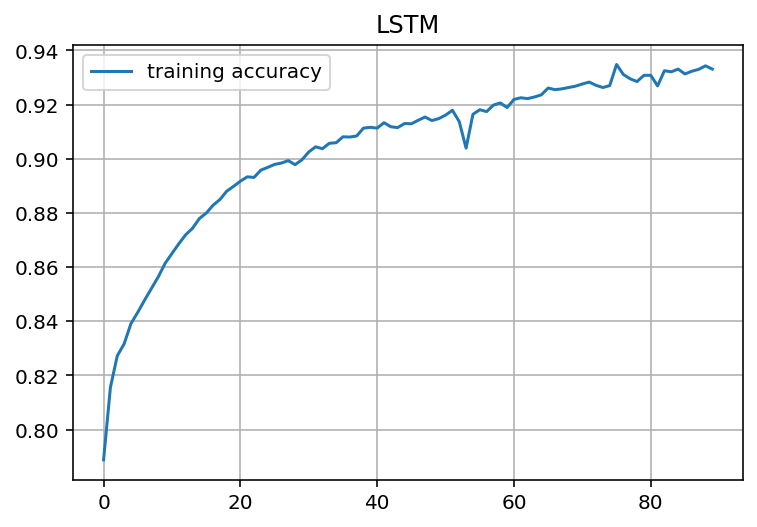

In [ ]:
import matplotlib.pyplot as plt
import pickle
f = open('history model-LSTM.pckl','rb')
hist = pickle.load(f)
f.close()
plt.plot(hist['acc'], label="training accuracy")
plt.grid(True)
plt.title("LSTM")
plt.legend()
plt.show()
plt.savefig('accuracy model-LSTM.png', dpi=300, bbox_inches='tight')
plt.close()

# phát nhạc từ midi


## cài thư viện


In [ ]:
!sudo apt install -y fluidsynth



Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  fluid-soundfont-gm libfluidsynth2 libinstpatch-1.0-2 qsynth
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs timidity jackd musescore
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libfluidsynth2 libinstpatch-1.0-2 qsynth
  timgm6mb-soundfont
0 upgraded, 6 newly installed, 0 to remove and 21 not upgraded.
Need to get 126 MB of archives.
After this operation, 157 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fluid-soundfont-gm all 3.1-5.1 [119 MB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 libinstpatch-1.0-2 amd64 1.1.2-2build1 [238 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/unive

In [ ]:
!pip install --upgrade pyfluidsynth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pretty_midi


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 30.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 KB 5.8 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591954 sha256=921f7b4e517f1dadfe3317d9cef3ffc1e81568d6b7d9962604d72df3acdfbce1
  Stored in directory: /root/.cache/pip/wheels/2a/5a/e3/30eeb9a99350f3f7e21258fcb132743eef1a4f49b3505e76b6
Successfully built pretty_midi


## hiển thị

In [ ]:
import pretty_midi
import fluidsynth
from IPython import display

MIDI_FILE_PATH = "./melody_0.mid"
_SAMPLING_RATE = 44100
def display_audio(file_path, seconds=30):

  pm = pretty_midi.PrettyMIDI(file_path)
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  if seconds== -1:
    waveform_short = waveform
  else:
    # Take a sample of the generated waveform to mitigate kernel resets
    waveform_short = waveform[:seconds*_SAMPLING_RATE]

  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

# Tạo melody tu model


## class tạo giai điệu


In [ ]:


class MelodyGenerator:
    """lớp load model và tạo ra giai điệu"""

    def __init__(self, model_path="model.h5",):
        """Constructor that initialises TensorFlow model"""
        custom_objects = {"attention": attention}
        self.model_path = model_path
        self.model = keras.models.load_model(model_path,custom_objects=custom_objects)


        with open(MAPPING_PATH, "r") as fp:
            self._mappings = json.load(fp)

        self._start_symbols = ["/"] * SEQUENCE_LENGTH


    def generate_melody(self, seed, num_steps, max_sequence_length, temperature):
        """Generates a melody using the DL model and returns a midi file.

        :param seed (str): Melody seed with the notation used to encode the dataset
        :param num_steps (int): Number of steps to be generated
        :param max_sequence_len (int): Max number of steps in seed to be considered for generation
        :param temperature (float): Float in interval [0, 1]. Numbers closer to 0 make the model more deterministic.
            A number closer to 1 makes the generation more unpredictable.

        :return melody (list of str): List with symbols representing a melody
        """

        # create seed with start symbols
        seed = seed.split()
        melody = seed
        seed = self._start_symbols + seed

        # map seed to int
        seed = [self._mappings[symbol] for symbol in seed]

        for _ in range(num_steps):

            # limit the seed to max_sequence_length
            seed = seed[-max_sequence_length:]

            # one-hot encode the seed
            onehot_seed = keras.utils.to_categorical(seed, num_classes=len(self._mappings))
            # (1, max_sequence_length, num of symbols in the vocabulary)
            onehot_seed = onehot_seed[np.newaxis, ...]

            # make a prediction
            probabilities = self.model.predict(onehot_seed)[0]
            # [0.1, 0.2, 0.1, 0.6] -> 1
            output_int = self._sample_with_temperature(probabilities, temperature)

            # update seed
            seed.append(output_int)

            # map int to our encoding
            output_symbol = [k for k, v in self._mappings.items() if v == output_int][0]

            # check whether we're at the end of a melody
            if output_symbol == "/":
                break

            # update melody
            melody.append(output_symbol)

        return melody


    def _sample_with_temperature(self, probabilites, temperature):
        """Samples an index from a probability array reapplying softmax using temperature

        :param predictions (nd.array): Array containing probabilities for each of the possible outputs.
        :param temperature (float): Float in interval [0, 1]. Numbers closer to 0 make the model more deterministic.
            A number closer to 1 makes the generation more unpredictable.

        :return index (int): Selected output symbol
        """
        predictions = np.log(probabilites) / temperature
        probabilites = np.exp(predictions) / np.sum(np.exp(predictions))

        choices = range(len(probabilites)) # [0, 1, 2, 3]
        index = np.random.choice(choices, p=probabilites)

        return index


    def save_melody(self, melody, step_duration=0.25, format="midi", file_name="mel.mid"):
        """Converts a melody into a MIDI file

        :param melody (list of str):
        :param min_duration (float): Duration of each time step in quarter length
        :param file_name (str): Name of midi file
        :return:
        """

        # create a music21 stream
        stream = m21.stream.Stream()

        start_symbol = None
        step_counter = 1

        # parse all the symbols in the melody and create note/rest objects
        for i, symbol in enumerate(melody):

            # handle case in which we have a note/rest
            if symbol != "_" or i + 1 == len(melody):

                # ensure we're dealing with note/rest beyond the first one
                if start_symbol is not None:

                    quarter_length_duration = step_duration * step_counter # 0.25 * 4 = 1

                    # handle rest
                    if start_symbol == "r":
                        m21_event = m21.note.Rest(quarterLength=quarter_length_duration)

                    # handle note
                    else:
                        m21_event = m21.note.Note(int(start_symbol), quarterLength=quarter_length_duration)

                    stream.append(m21_event)

                    # reset the step counter
                    step_counter = 1

                start_symbol = symbol

            # handle case in which we have a prolongation sign "_"
            else:
                step_counter += 1

        # write the m21 stream to a midi file
        stream.write(format, file_name)


## tạo giai điệu nhạc và lưu file midi

In [ ]:
model_LSTM_path = './model.h5'
model_Bi_LSTM_Attention_LSTM_path = './model-Bi-LSTM+attention+LSTM.h5'
model_LSTM_attention_path = './model-LSTM+attention.h5'
mg = MelodyGenerator(model_path=model_Bi_LSTM_Attention_LSTM_path)
song = m21.converter.parse("./midi/hpbd_seed.mid")
# song  = transpose(song)
song_encoded = encode_song(song)
print(song_encoded)
seed = "67 _ 67 _ 67 _ _ 65 64 _ 64 _ 64 _ _"
seed2 = "67 _ _ _ _ _ 65 _ 64 _ 62 _ 60 _ _ _"
melody = mg.generate_melody(song_encoded, 300, SEQUENCE_LENGTH, 0.7)
print(melody)
mg.save_melody(melody,file_name="melody.mid" )

r _ _ _ _ _ _ _ 67 _ 67 _ 69 _ _ _ 67 _ _ _ 72 _ _ _ 71 _ _ _ _ _ _ _ 67 _ 67 _ 69 _ _ _ 67 _ _ _ 74 _ _ _ 72 _ _ _
1/1 [==============================] - 0s 53ms/step
['r', '_', '_', '_', '_', '_', '_', '_', '67', '_', '67', '_', '69', '_', '_', '_', '67', '_', '_', '_', '72', '_', '_', '_', '71', '_', '_', '_', '_', '_', '_', '_', '67', '_', '67', '_', '69', '_', '_', '_', '67', '_', '_', '_', '74', '_', '_', '_', '72', '_', '_', '_', '_', '_', '_', '_', '67', '_', '_', '_', '65', '_', '_', '_', '69', '_', '_', '_', '67', '_', '_', '_', '65', '_', '_', '_', '69', '_', '_', '_', '67', '_', '_', '_', '_', '_', '_', '_', '64', '_', '_', '_', '62', '_', '_', '_', '60', '_', '_', '_', '_', '_', '_', '_', 'r', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', 'r', '_', '_', '_']


In [ ]:
display_audio("melody.mid",-1)